LOADING DATASET FOR CLEANING AND ANALYSIS


In [ ]:
import pandas as pd
import csv

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("openfoodfacts/world-food-facts")

100%|██████████| 109M/109M [00:00<00:00, 130MB/s]

Extracting files...


In [ ]:
import os
file_list = os.listdir(path)

In [ ]:
import pandas as pd


file_path = os.path.join(path, file_list[0])

# Load the TSV file into a pandas DataFrame
data = pd.read_csv(file_path, sep='\t')

/root/.cache/kagglehub/datasets/openfoodfacts/world-food-facts/versions/5/en.openfoodfacts.org.products.tsv


/tmp/ipython-input-3883020196.py:8: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep='\t')


In [ ]:

data.shape

(356027, 163)

In [ ]:
# Dropping columns that are entirely empty
data.dropna(axis=1, how='all', inplace=True)

# Calculating the percentage of missing values for each column
missing_percentages = data.isnull().sum() / len(data) * 100





In [ ]:
data.shape

(356027, 147)

In [ ]:
categories_tags = data['categories_tags']
categories_tags.isnull().sum()

np.int64(252752)

***USER STORY 1***:DATA INGESTION & CLEAN UP


In [ ]:
### Taking the columns needed For Analysis
needed = [
    "product_name",
    "categories_tags",
    "energy_100g",
    "fat_100g",
    "sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "ingredients_text"
]

[col for col in needed if col in data.columns]


['product_name',
 'categories_tags',
 'energy_100g',
 'fat_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'ingredients_text']

In [ ]:
###Filtering Out the Data That Will Be Used For Analysis
data_needed = data[needed].copy()
data_needed.shape


(356027, 8)

In [ ]:
data_user1 = data_needed.dropna(
    subset=["product_name", "sugars_100g", "proteins_100g"]
)
data_user1.shape

(275113, 8)

In [ ]:
### Removing biologically impossible data
data_user1 = data_user1[
    (data_user1["sugars_100g"].between(0, 100)) &
    (data_user1["proteins_100g"].between(0, 100))
]

data_user1.shape



(275095, 8)

**STORY 2:** The Category Wrangler

In [ ]:
###Checking contents of the category_tag
data_needed["categories_tags"].isnull().sum()

np.int64(252752)

In [ ]:
data_needed["categories_tags"]

,categories_tags
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
356022,NaN
356023,"en:salty-snacks,en:appetizers,en:chips-and-fri..."
356024,NaN
356025,NaN


In [ ]:
##Removing Rows with Nans or missing values
data_user2 = data_needed.dropna(subset=['categories_tags'])
data_user2

,product_name,categories_tags,energy_100g,fat_100g,sugars_100g,fiber_100g,proteins_100g,ingredients_text
47,Filet de bœuf,fr:filet-de-boeuf,NaN,NaN,NaN,NaN,NaN,NaN
176,Salade Cesar,"en:plant-based-foods-and-beverages,en:plant-ba...",1210.0,12.0,0.0,2.00,22.00,INGREDIENTS : LAITUE. VINAIGRETTE (HUILE DE CA...
177,Danoises à la cannelle roulées,"en:sugary-snacks,en:biscuits-and-cakes,en:past...",1520.0,14.4,28.1,2.05,4.79,"Ingrédients: Pâte (farine, eau, beurre, sucre,..."
179,Flute,"en:plant-based-foods-and-beverages,en:plant-ba...",NaN,NaN,NaN,NaN,NaN,Wheat
182,Chaussons tressés aux pommes,"en:sugary-snacks,en:biscuits-and-cakes,en:past...",1090.0,10.7,24.7,2.00,3.33,"Ingrédients : Pâte (farine, margarines d'huile..."
...,...,...,...,...,...,...,...,...
356016,Szprot w oleju roslinnym,pl:szprot,NaN,NaN,NaN,NaN,NaN,NaN
356017,Thé vert Earl grey,"en:plant-based-foods-and-beverages,en:beverage...",21.0,0.2,0.5,0.20,0.50,"thé vert, arôme naturel bergamote avec autres ..."
356019,Rillette d'oie,"en:meats,en:spreads,en:prepared-meats,en:salte...",NaN,NaN,NaN,NaN,NaN,"viande d'oie, graisse de canard, épices, sel, ..."
356020,NaN,"en:plant-based-foods-and-beverages,en:plant-ba...",NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def parse_tags(tags):
    if pd.isna(tags):
        return []
    return [t.replace("en:", "").strip() for t in tags.split(",")]


In [ ]:
### Creating the primary categories to be assigned to products
category_map = {
    "Sweet Snacks": [
        "sweet-snacks", "chocolate", "biscuits", "cookies", "cakes", "candies", "desserts"
    ],
    "Savory Snacks": [
        "salty-snacks", "crisps", "chips", "popcorn", "nuts", "pretzels"
    ],
    "Dairy & Protein": [
        "dairy", "cheese", "yogurt", "milk", "protein", "whey", "meat" ,"poultries","chicken","fishes","eggs"
    ],
    "Fruits & Plant-Based": [
        "fruits", "vegetables", "plant-based","plant-based-foods" ,"legumes"
    ],
    "Beverages": [
        "beverages", "drinks", "juice", "tea", "coffee"
    ]
}



In [ ]:
## Creating the Logic For Assigning a Product To a category
def assign_primary_category(tags):
    parsed_tags = parse_tags(tags)

    for category, keywords in category_map.items():
        if any(keyword in tag for tag in parsed_tags for keyword in keywords):
            return category

    return "Other"

In [ ]:
###Applying Logic to Datasets
data_needed["primary_category"] = data_needed["categories_tags"].apply(assign_primary_category)
data_user2["primary_category"] = data_user2["categories_tags"].apply(assign_primary_category)


/tmp/ipython-input-3999384004.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_user2["primary_category"] = data_user2["categories_tags"].apply(assign_primary_category)


In [ ]:
data_user2["primary_category"]

,primary_category
47,Other
176,Fruits & Plant-Based
177,Sweet Snacks
179,Fruits & Plant-Based
182,Sweet Snacks
...,...
356016,Other
356017,Fruits & Plant-Based
356019,Dairy & Protein
356020,Savory Snacks


In [ ]:
###Confirming if categories exists in all records
data_user2["primary_category"].value_counts()

,count
primary_category,
Fruits & Plant-Based,27132
Other,22045
Dairy & Protein,21786
Sweet Snacks,16497
Beverages,11179
Savory Snacks,4636


In [ ]:
###Sanity check of category assigment
check_data_user2 = data_user2[
    ["product_name", "categories_tags", "primary_category"]
]
check_data_user2.head(10)


,product_name,categories_tags,primary_category
47,Filet de bœuf,fr:filet-de-boeuf,Other
176,Salade Cesar,"en:plant-based-foods-and-beverages,en:plant-ba...",Fruits & Plant-Based
177,Danoises à la cannelle roulées,"en:sugary-snacks,en:biscuits-and-cakes,en:past...",Sweet Snacks
179,Flute,"en:plant-based-foods-and-beverages,en:plant-ba...",Fruits & Plant-Based
182,Chaussons tressés aux pommes,"en:sugary-snacks,en:biscuits-and-cakes,en:past...",Sweet Snacks
183,Pain Burger Artisan,fr:boulange,Other
184,lentilles vertes,"en:plant-based-foods-and-beverages,en:plant-ba...",Fruits & Plant-Based
185,Root Beer,"en:beverages,en:carbonated-drinks,en:sodas,en:...",Beverages
186,Biscuits sablés fourrage au cacao,"en:sugary-snacks,en:biscuits-and-cakes,en:bisc...",Sweet Snacks
187,Quiche Lorraine,"en:meals,en:pizzas-pies-and-quiches,en:quiches...",Other


In [ ]:
### Selecting the necessary columns for the rest of user story for analysis

dash_df = data_user2[
    ["product_name",
     "primary_category",
     "proteins_100g",
     "sugars_100g",
     "fiber_100g",
     "fat_100g",
     "energy_100g",
     "ingredients_text"]
]
dash_df



,product_name,primary_category,proteins_100g,sugars_100g,fiber_100g,fat_100g,energy_100g,ingredients_text
47,Filet de bœuf,Other,NaN,NaN,NaN,NaN,NaN,NaN
176,Salade Cesar,Fruits & Plant-Based,22.00,0.0,2.00,12.0,1210.0,INGREDIENTS : LAITUE. VINAIGRETTE (HUILE DE CA...
177,Danoises à la cannelle roulées,Sweet Snacks,4.79,28.1,2.05,14.4,1520.0,"Ingrédients: Pâte (farine, eau, beurre, sucre,..."
179,Flute,Fruits & Plant-Based,NaN,NaN,NaN,NaN,NaN,Wheat
182,Chaussons tressés aux pommes,Sweet Snacks,3.33,24.7,2.00,10.7,1090.0,"Ingrédients : Pâte (farine, margarines d'huile..."
...,...,...,...,...,...,...,...,...
356016,Szprot w oleju roslinnym,Other,NaN,NaN,NaN,NaN,NaN,NaN
356017,Thé vert Earl grey,Fruits & Plant-Based,0.50,0.5,0.20,0.2,21.0,"thé vert, arôme naturel bergamote avec autres ..."
356019,Rillette d'oie,Dairy & Protein,NaN,NaN,NaN,NaN,NaN,"viande d'oie, graisse de canard, épices, sel, ..."
356020,NaN,Savory Snacks,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
###Removing Missing Values In Required Columns
dash_df = dash_df.dropna(
    subset=["proteins_100g", "sugars_100g", "primary_category"]
)
dash_df.isnull().sum()

,0
product_name,461
primary_category,0
proteins_100g,0
sugars_100g,0
fiber_100g,28435
fat_100g,3198
energy_100g,71
ingredients_text,7566


In [ ]:
dash_df.columns

Index(['product_name', 'primary_category', 'proteins_100g', 'sugars_100g',
       'fiber_100g', 'fat_100g', 'energy_100g', 'ingredients_text'],
      dtype='object')

USER STORY 3:The Nutrient Matrix

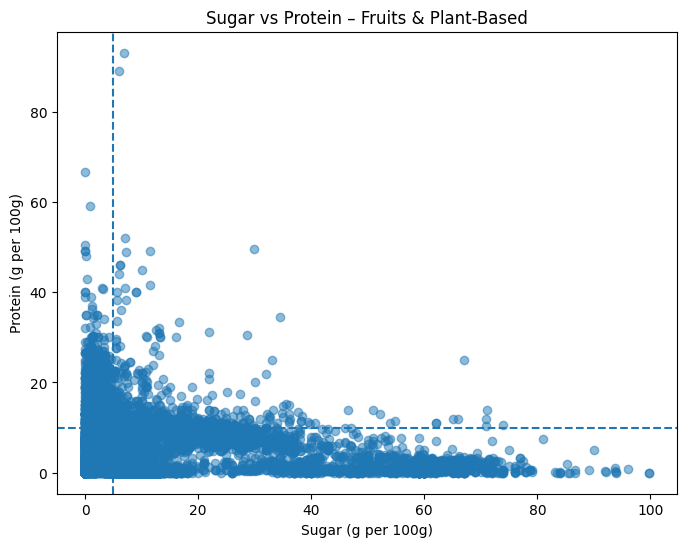

In [ ]:
###Creating the Scatter Plot
import matplotlib.pyplot as plt
import seaborn as sns
category = "Fruits & Plant-Based"

subset = dash_df[dash_df["primary_category"] == category]

plt.figure(figsize=(8, 6))
plt.scatter(
    subset["sugars_100g"],
    subset["proteins_100g"],
    alpha=0.5
)

plt.axvline(x=5, linestyle="--")
plt.axhline(y=10, linestyle="--")

plt.title(f"Sugar vs Protein – {category}")
plt.xlabel("Sugar (g per 100g)")
plt.ylabel("Protein (g per 100g)")
plt.show()


In [ ]:
#Saving the dash_df DataFrame to a CSV file
dash_df.to_csv('dash_df.csv', index=False)



In [ ]:
##USER 5 Finding high proteing ingredients
high_protein_df = dash_df[dash_df["proteins_100g"] >= 20]

high_protein_df["ingredients_text"] = (
    high_protein_df["ingredients_text"]
    .str.lower()
)

high_protein_df


/tmp/ipython-input-1380820798.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_protein_df["ingredients_text"] = (


,product_name,primary_category,proteins_100g,sugars_100g,fiber_100g,fat_100g,energy_100g,ingredients_text
176,Salade Cesar,Fruits & Plant-Based,22.00,0.00,2.00,12.00,1210.0,ingredients : laitue. vinaigrette (huile de ca...
307,Whey Protein aus Molke Vanilla,Dairy & Protein,78.05,6.00,0.10,4.60,1644.0,molkenproteinkonzentrat 99%(_wheyproteinkonzen...
309,Whey Protein aus Molke 1000 Gramm Vanilla,Dairy & Protein,78.05,6.00,0.10,4.60,1644.0,molkenproteinkonzentrat 99%(_wheyproteinkonzen...
312,Whey Protein aus Molke 500 Gramm Vanilla,Dairy & Protein,78.05,6.00,0.10,4.60,1644.0,molkenproteinkonzentrat 99%(_wheyproteinkonzen...
547,Honey roast ham,Other,24.50,2.90,0.10,2.00,564.0,porc d’origine britannique (élaboré avec 120 g...
597,British Beef Braising Steak,Dairy & Protein,22.10,0.00,0.00,6.40,615.0,beef braising steak
719,Cornish Cove Cheddar,Dairy & Protein,22.90,1.10,1.20,34.40,1720.0,fromage cheddar cornish cove (_lait_) • piment...
733,Mild Cheddar with Onions & Chives,Dairy & Protein,21.70,0.40,0.80,32.90,1618.0,_fromage_ cheddar jeune (_lait_) (94%) . oigno...
1900,Crunchy Peanut Butter,Savory Snacks,25.00,3.12,9.40,50.00,2485.0,"roasted peanuts, salt."
2375,Soynuts Roasted & Salted,Savory Snacks,36.70,3.33,16.70,26.70,2090.0,organic roasted _soy_ nuts (organic _soybeans_...


In [ ]:
protein_keywords = [
    "whey", "salmon", "soy beabs",
    "soy", "cheddar cheese", "fish",
    "ground_almond", "egg", "molkenproteinkonzentrat",
    "roasted peanuts","pistaches","beef","cheddar cheese"
    ,"milk","pork","_amandes_","chicken","fromage"
]


In [ ]:
### Finding  the top3 most common Ingredients
from collections import Counter

counter = Counter()

for ingredients in high_protein_df["ingredients_text"].dropna():
    for keyword in protein_keywords:
        if keyword in ingredients:
            counter[keyword] += 1

counter.most_common(20)
(####From the keywords used, the most common ingredients used for High protein products were fromage(cheese in English),milk and amandes
)

[('fromage', 110),
 ('milk', 88),
 ('_amandes_', 74),
 ('pistaches', 62),
 ('pork', 58),
 ('soy', 48),
 ('whey', 30),
 ('cheddar cheese', 20),
 ('chicken', 20),
 ('beef', 17),
 ('salmon', 17),
 ('fish', 13),
 ('roasted peanuts', 11),
 ('egg', 11),
 ('molkenproteinkonzentrat', 5)]